# <center> **Deep Learning: Supervised Seafloor classification with CNN** </center>
## <center> Machine Learning Programming Exercise 8 part 1: Initiation au Convolutional Neural Networks </center>

| <font size=6,font color='red'>Monôme / binôme</font> | <font size=6,font color='red'>Nom</font> | <font size=6,font color='red'>Prénom</font> |
|:-------------: |:----------- |:------ |
| binôme 1 | <span style="color:red">DUBEE</span> | <span style="color:red">Melvin</span> |
| binôme 2 | <span style="color:red">ROUDAUT</span> | <span style="color:red">Tanguy</span> |


# 0. Setup

## 0.1 Colab or not

In [1]:
# common imports
import sys,os,glob

# Colab preamble
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:

  # mount google drive directories
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)


  # ----------- Your code here --------------------->
  # replace the ipynb_name (below) with the name of your jupyter notebook file

  ipynb_name = 'tp2.1_tuto_cnns_startercode.ipynb'

  # ------------------------------------------------>

  ipynb_name = glob.glob(os.getcwd() + '/gdrive/MyDrive/machine_learning/' + ipynb_name, recursive = True)
  code_folder = os.path.dirname(ipynb_name[0])

  # change to the right folder
  %cd "$code_folder"
  !ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/machine_learning
dataset        partie2.ipynb  tp2.1_tuto_cnns_startercode.ipynb
partie1.ipynb  results	      tp2.2_learning_cnns_fine_tuning_startercode.ipynb


## 0.2 Import packages

In [2]:
# Common imports
import numpy as np
import os

# machine learning packages
import sklearn
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# options to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



## 0.3 Random seed

In [3]:
# to make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 1. What is a Convolution? et comment filtrer une image avec tensorflow?

Chargez des images au hasard avec sklearn:

In [4]:
# Import useful packages
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape


Chaque filtre est caractérisé:
- un support: une longueur et une largeur;
- un déplacement (stride);
- un nombre de canaux.

La dimension de l'image filtrée en sortie est conditionnée par la méthode de padding (voir [ici](https://www.tensorflow.org/api_docs/python/tf/nn#notes_on_padding_2)).


Création de deux filtres de support (7,7):

In [5]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line


Afficher ces filtres comme une image:

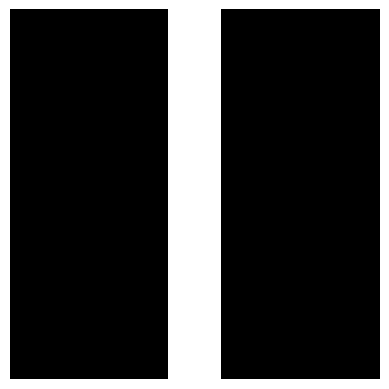

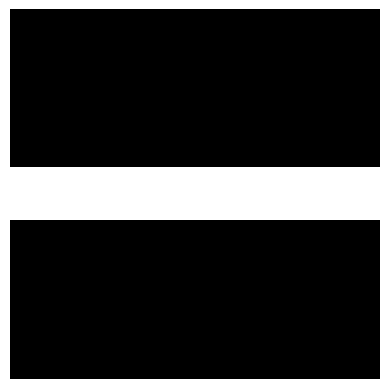

In [6]:
plt.figure()
plt.imshow(filters[:, :, 0, 0], cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(filters[:, :, 0, 1], cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()

Avec tensorflow, voila comment filtrer par convolution (déplacement de la fenetre de 1 pixel avec un padding permettant d'obtenir la même taille d'images en sortie) des images par un ensemble de filtres:

In [7]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

L'affichage du filtrage de la première image par le second filtre est alors possible avec la commande suivante. Il est à noter que cette sortie dans le cas d'un CNN est appelé `feature map` ou `carte de descripteurs`.

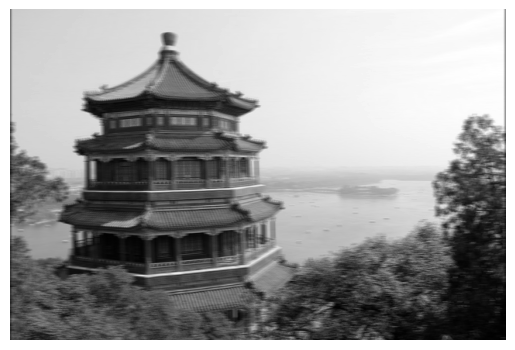

In [8]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

ou

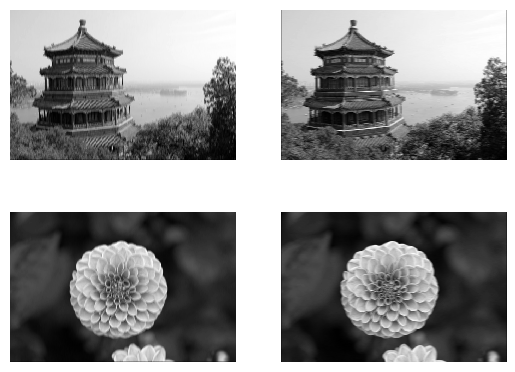

In [9]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plt.imshow(outputs[image_index, :, :, feature_map_index], cmap="gray", interpolation="nearest")
        plt.axis("off")

plt.show()

On peut zoomer sur les sorties.

In [10]:
def crop(images):
    return images[150:220, 130:250]

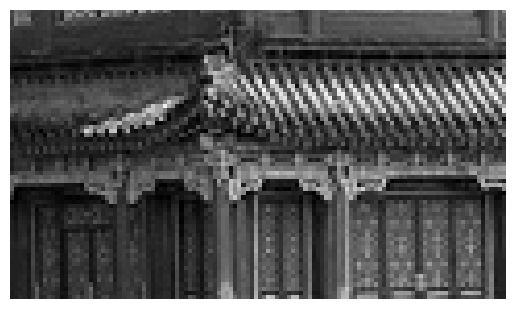

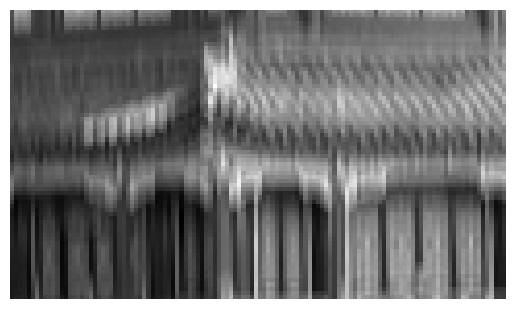

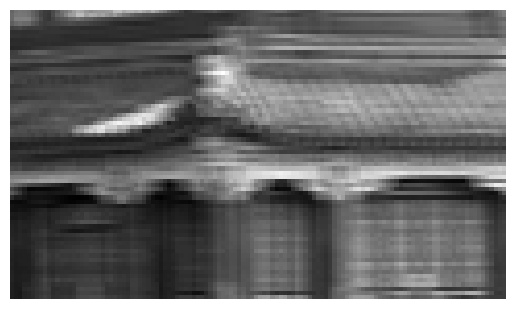

In [11]:
plt.imshow(crop(images[0, :, :, 0]), cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plt.imshow(crop(outputs[0, :, :, feature_map_index]), cmap="gray", interpolation="nearest")
    plt.axis("off")
    plt.show()

**Question:** Reprenez la partie précédente en remplacant les filtres par les filtres définis dans le slide intitulé "Example of convolution filter example applied to image" de mon cours sur les CNN. Montrez les résultats.

<Figure size 640x480 with 0 Axes>

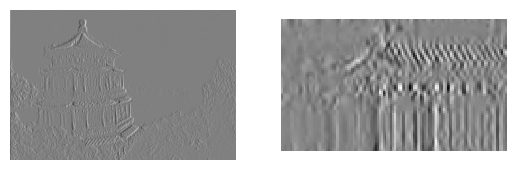

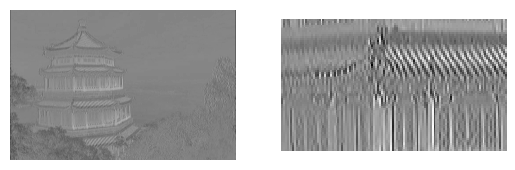

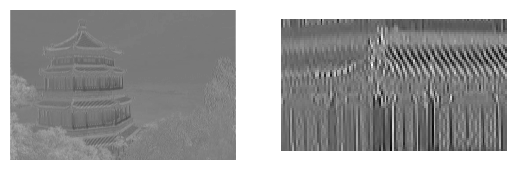

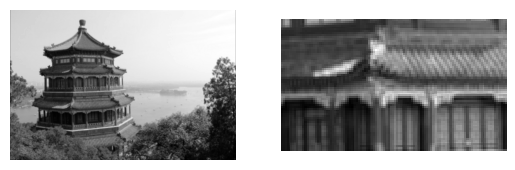

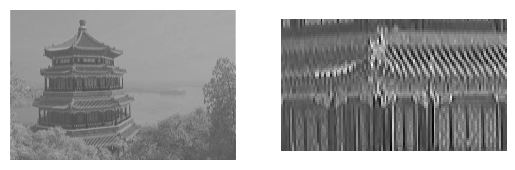

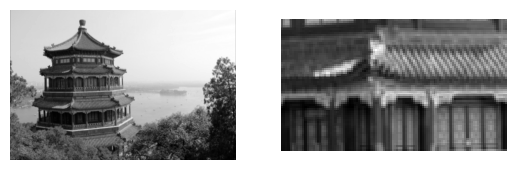

<Figure size 640x480 with 0 Axes>

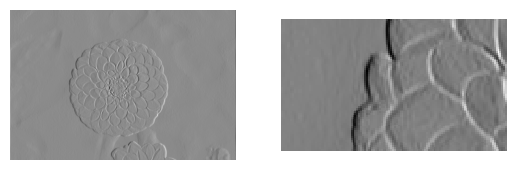

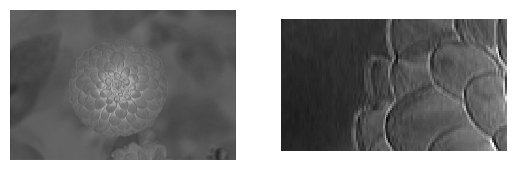

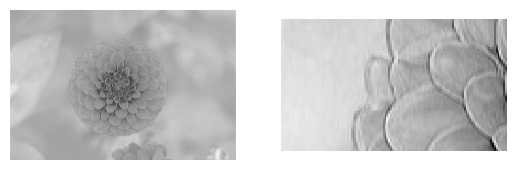

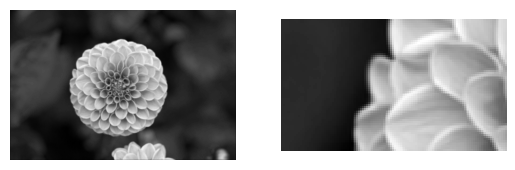

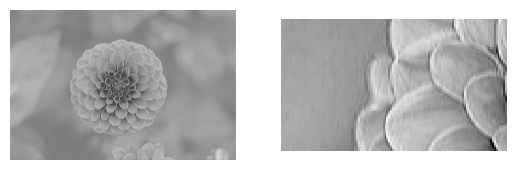

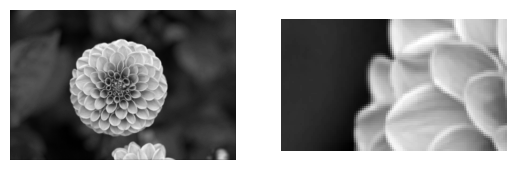

In [12]:
# ----------- Your code here --------------------->

filters = np.zeros(shape=(3, 3, channels, 6), dtype=np.float32)
filters[:, :, :, 0] = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])                # Edge Detection 1
filters[:, :, :, 1] = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])                 # Edge Detection 2
filters[:, :, :, 2] = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])          # Edge Detection 3
filters[:, :, :, 3] = 1/9 * np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])            # Box Blur
filters[:, :, :, 4] = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])              # Sharpen
filters[:, :, :, 5] = 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])           # Gaussian Blur

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.figure()
for i in range(6):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(outputs[0, :, :, i], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(crop(outputs[0, :, :, i]), cmap="gray", interpolation="nearest")
    plt.axis("off")

plt.figure()
for i in range(6):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(outputs[1, :, :, i], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(crop(outputs[1, :, :, i]), cmap="gray", interpolation="nearest")
    plt.axis("off")

#------------------------------------------------>


## 2. Couches caractéristiques d'un CNN

### 2.1 Convolutional Layer / couche de convolutions

Le premier élément d'un réseau de convolution est la couche de convolution (`keras.layers.Conv2D()` [tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)) permettant:
- de créer rapidement une banque de filtres (avec leurs caractéristiques) qui seront appris lors de l'apprentissage
- initialisés aléatoirement (par défaut `kernel_initializer`)
- d'appliquer une non-linéarité après chaque filtre (`activation`)

La sortie est alors un tenseur de dimension au moins 4 donné par `activation(conv2d(inputs, kernel) + bias)`.

**Question**: créer une couche de convolution 2D:
- 32 filtres de taille (3,3)
- le déplacement du filtre sera de 1 pixel
- la taille de la sortie sera identique à la taille de l'image d'entrée
- l'initialisation des filtres sera faite selon la méthode 'glorot_uniform'
- la non-linéarité sera de type 'relu'

In [16]:
# ----------- Your code here --------------------->

conv = keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(), activation=keras.activations.relu, input_shape=(height, width, channels))

# ------------------------------------------------>

Il suffit alors de filtrer les images par la commande:

In [17]:
out = conv(images)
out.shape

TensorShape([2, 427, 640, 32])

**Question:** Afficher la feature map du 16ème filtre pour la seconde image

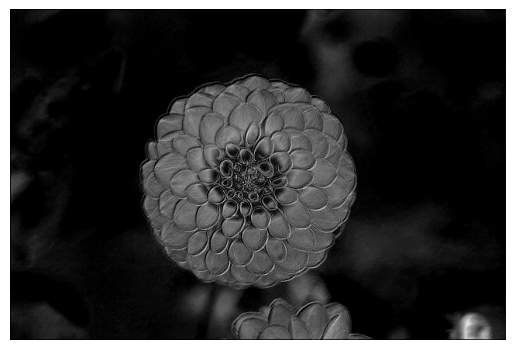

In [18]:
# ----------- Your code here --------------------->

feature_map = out[1, :, :, 15]
plt.imshow(feature_map, cmap='gray')
plt.axis("off")
plt.show()
# ------------------------------------------------>

### 2.2. Pooling layer / Couche de mise en commun
La seconde couche caractéristique est la couche de pooling qui permet:
- de diminuer la résolution spatiale
- de diminuer le bruit dans l'information et d'augmenter sa pertinence
- de produire une décomposition hierarchique de l'information

Deux types de pooling sont en général utilisés (soit l'un soit l'autre):
- max pooling
- average pooling

Le seul paramètre à fixer est la taille du support de mise en commun (`pool_size`).
Aucun paramétre n'est `apprenable` lors de la phase d'apprentissage.


#### 2.2.1. Couche de Max pooling

In [19]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [20]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

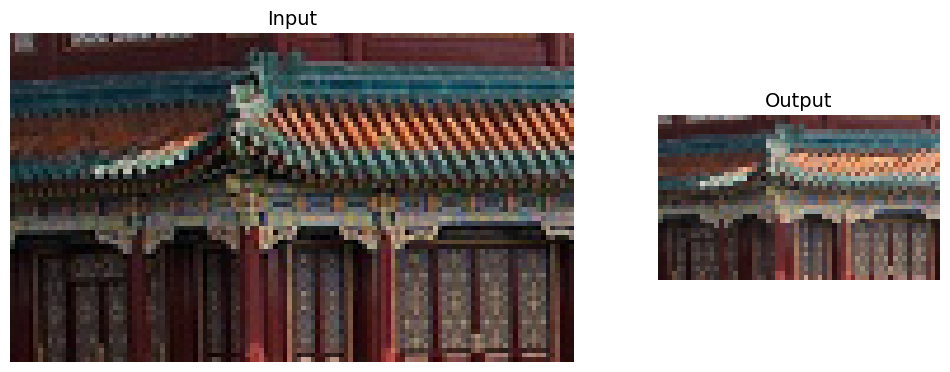

In [21]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

#### 2.2.2. Couche de Average pooling

In [22]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [23]:
output_avg = avg_pool(cropped_images)

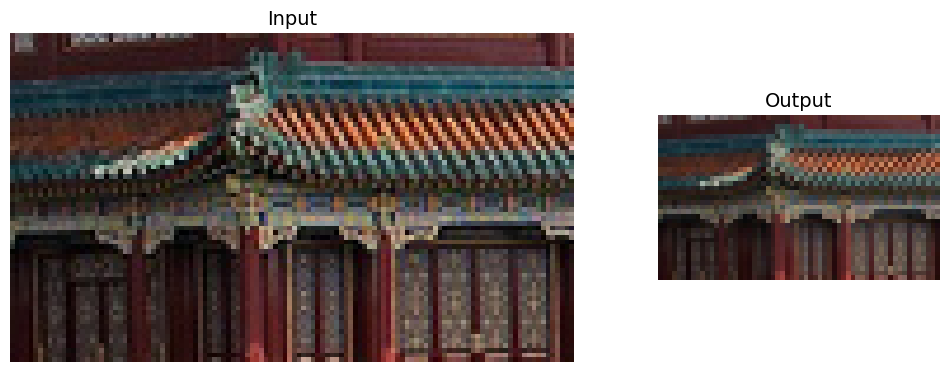

In [24]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## 3. Définir, utiliser et apprendre un CNN avec la base d'images Fashion MNIST

### 3.1. Import de la base d'images

In [25]:
# lecture et séparation du dataset en trois ensembles
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


4422102/4422102 [==============================] - 0s 0us/step


### 3.2. Normalisation de la base d'images

In [26]:
# normalisation (notez bien que la moyenne et std sont estimés sur le training set)
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# on rajoute une dimension channel pour s'adapter au formalisme de tensorflow
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

### 3.3. Création de l'architecture du modèle/réseau de neurones

**Question:** Créer une architecture basée sur:
- un extracteur de descripteurs (Features) composé de:
    - une couche de 64 filtres de taille (7,7) avec des activations de type relu, un padding same et acceptant en entrée une image de taille (28,28) en niveau de gris
    - une couche de max pooling de support (2,2)
    - une couche de 128 filtres de taille (3,3) avec des activations de type relu, un padding same
    - une couche de 128 filtres de taille (3,3) avec des activations de type relu, un padding same
    - une couche de max pooling de support (2,2)
    - une couche de 256 filtres de taille (3,3) avec des activations de type relu, un padding same
    - une couche de 256 filtres de taille (3,3) avec des activations de type relu, un padding same
    - une couche de max pooling de support (2,2)
- une couche permettant la vectorisation des feature map (Flattenisation) et faisant le lien entre extracteur de descripteurs et classifieur
- un classifieur composé:
    - une couche Fully connected ou Dense de 128 neurones avec des activations de type relu
    - une couche Dropout (paramètre 0.5) pour lutter contre l'overfitting
    - une couche Fully connected ou Dense de 64 neurones avec des activations de type relu
    - une couche Dropout (paramètre 0.5) pour lutter contre l'overfitting
    - une couche Fully connected ou Dense finale d'un nombre de neurones = au nombre de classes et des activations de type `softmax`
**

In [27]:
# ----------- Your code here --------------------->
num_classes = np.unique(y_train).shape[0]
print(num_classes)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# ------------------------------------------------>

model.summary()

10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 256)       

**Question:**
- Quel est le nombre de paramètres de ce modèle?
- Quel est le nombre de paramètres apprenables de ce modèle?
- Quel est le nombre de paramètres apprenables de la dernière couche? Expliquez.
- Quel est le nombre de paramètres apprenables de la première couche? Expliquez.
- Pourquoi l'activation finale est de type softmax?**

Ce modèle est composé de 1413834 paramètres. Le nombre de paramètres apprenables de ce modèle est le même.

Dans la dernière couche, on a 650 paramètres apprenables. En effet, la dernière couche est une couche dense, ce qui implique que tous les paramètres restant vont être connectés en entrée de la dernière couche et seront donc apprenables. L'avant dernière couche ayant 64 neurones et la dernière 10 neurones avec pour chaque chaque neurones un biai, cela donne (10 + 10 x 1) x 64 = 650

Dans la première couche, on a 3200 paramètres apprenables, c'est lié aux 64 filtres de taille (7, 7) de profondeur 1 (niveau de gris) et le biai de chaque neurone (64 x (7 x 7 + 1) = 3200).

L'activation finale est de type softmax puisque le modèle doit donnée une probabilité à chaque classe en sortie.

### 3.4. Apprentissage du modèle

#### 3.4.1. Choix de la tâche à effectuer = choix de la fonction de loss/pertes/coûts à minimiser
see [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses)

In [28]:
loss_fcn = "sparse_categorical_crossentropy"  # par alias
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()# sans alias
# attention le sparse fait référence au fait qu'on entre les labels sous la forme d'index et non encodés en OneHot

#### 3.4.2. Comment résoudre la tâche de minimisation (choix de l'algorithme d'optimisation)
see [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

In [29]:
# choix de l'optimiseur (On verra cela plus en détail lors du cours sur l'apprentissage)
optimizer_fcn = "nadam" # par alias
optimizer_fcn = tf.keras.optimizers.experimental.Nadam() # sans alias

#### 3.4.3. Comment évaluer les performances (métriques de performance) lors de l'apprentissage
see [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [30]:
#metrics_fcn = ["accuracy"] # par alias
#metrics_fcn = [tf.keras.metrics.SparseCategoricalAccuracy()] # sans alias
metrics_fcn = tf.keras.metrics.SparseCategoricalAccuracy() # sans alias

#### 3.4.4. Apprendre avec Keras
see [here](https://www.tensorflow.org/guide/keras/train_and_evaluate)

In [31]:
# compilation ...
model.compile(loss=loss_fcn, optimizer=optimizer_fcn, metrics=metrics_fcn)

#... et entrainement
NB_EPOCHS = 10
history = model.fit(X_train, y_train, epochs=NB_EPOCHS, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 23s 10ms/step - loss: 0.7078 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.3694 - val_sparse_categorical_accuracy: 0.8712
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4215 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.3520 - val_sparse_categorical_accuracy: 0.8764
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3728 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.3062 - val_sparse_categorical_accuracy: 0.8910
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3326 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.2810 - val_sparse_categorical_accuracy: 0.8948
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.2899 - val_sparse_categorical_accuracy: 0.8936
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2884 

#### 3.4.5. Prédire avec Keras et le modèle appris

In [32]:
X_new = X_test[:10]
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 284ms/step


#### 3.4.6. Evaluer les performances du modèle appris

In [33]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2834 - sparse_categorical_accuracy: 0.9010


On voit qu'avec le modèle appris, le loss est de 30% et l'accuracy de 90%. Si l'on compare avec la partie 2 du TP7, on était à peu près sur les mêmes valeurs obtenues (avec un dataset différent!!!).

## 4. Utiliser un modèle CNN pré-entrainé

### 4.1. Construction du modèle

Keras intègre la possibilité de construire des modèles `classiques` de réseau de neurones de convolution et de télécharger les paramètres/poids déjà entrainés sur des bases de données `classiques`. Les différentes possibilités sont listées [ici](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

Par exemple, voila le code pour construire et télécharger le modèle ResNet50 dont les paramètres préentrainés sur la base d'images `classique` [ImageNet][https://www.image-net.org/].

In [34]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")
model.summary()


102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

Si l'on compare le résultat de ce modèle avec le précédent, on peut dire qu'il y a déjà plus de paramètres en jeu. Cette fois-ci nous avons des paramètres non entraînés.

### 4.2. Prétraitements des images

#### 4.2.1 Taille des images
Le modèle accepte n'importe quelle taille d'image (c'est un réseau de convolution!) mais comme on fait une décomposition hiérarchique (présence de pooling), la taille minimum des images doit être de [224,224] pour resnet50. Par ailleurs pour l'apprentissage, notez qu'il faut des images de taille fixe.

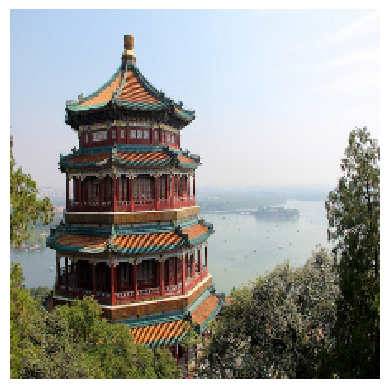

In [35]:
images_resized = tf.image.resize(images, [224, 224])
plt.imshow(images_resized[0], interpolation="nearest")
plt.axis("off")
plt.show()

#### 4.2.2 Normalisation

Les modèles pré-entraînés sont toujours entrainés dans des conditions qu'il faut reproduire si on veut les utiliser de manière optimale. On doit par exemple réaliser exactement les mêmes prétraitements. Dans certains cas, les modèles peuvent s'attendre à ce que les entrées soient mises à l'échelle de 0 à 1, ou de -1 à 1, etc.

Chaque modèle de `Keras` fournit une fonction `preprocess_input()` que vous pouvez utiliser pour prétraiter vos images. **Ces fonctions partent du principe que les valeurs des pixels sont comprises entre 0 et 255.** Nous devons donc les multiplier par 255 (puisque nous les avons précédemment mises à l'échelle dans la plage 0-1).


In [36]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized * 255)
inputs.shape

TensorShape([2, 224, 224, 3])

### 4.3. Prédiction des images par le modèle

Nous pouvons maintenant utiliser le modèle pré-entraîné pour faire des prédictions :

In [37]:
Y_proba = model.predict(inputs)
print(Y_proba.shape)


1/1 [==============================] - 1s 1s/step
(2, 1000)


Il existe également une fonction permettant de fournir des infos sur les prédictions. Voir [ici](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/decode_predictions)

In [38]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image #1
  n03530642 - honeycomb    49.81%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%



Les classes correctes (monastère et marguerite) apparaissent dans les trois premiers résultats pour les deux images. C'est plutôt bon si l'on considère que le modèle a dû choisir parmi 1000 classes.

Comme vous pouvez le constater, il est très facile de créer un bon classifieur d'images à l'aide d'un modèle pré-entraîné. D'autres modèles sont disponibles dans keras.applications , notamment plusieurs variantes de ResNet, des variantes de GoogLeNet comme InceptionV3 et Xception, des variantes de VGGNet, MobileNet et MobileNetV2 (des modèles légers pour les applications applications mobiles), et bien d'autres encore.


## 5. Apprendre un modèle par Transfer Learning

Que faire si vous voulez utiliser un classificateur d'images pour vos images qui ne font pas partie d'ImageNet ? Dans ce cas, vous pouvez tout de même bénéficier des modèles pré-entraînés pour réaliser l'apprentissage par transfert.

Dans cette partie, on va créer et apprendre un modèle pour classer les photos de fleurs, en réutilisant un modèle Xception pré-entrainé.

### 5.1 Chargement des données

Tout d'abord, chargeons le jeu de données en utilisant TensorFlow Datasets.

In [39]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [40]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [41]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [42]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [43]:
n_classes = info.features["label"].num_classes

In [44]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

Séparation en 3 ensembles de données

In [45]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)


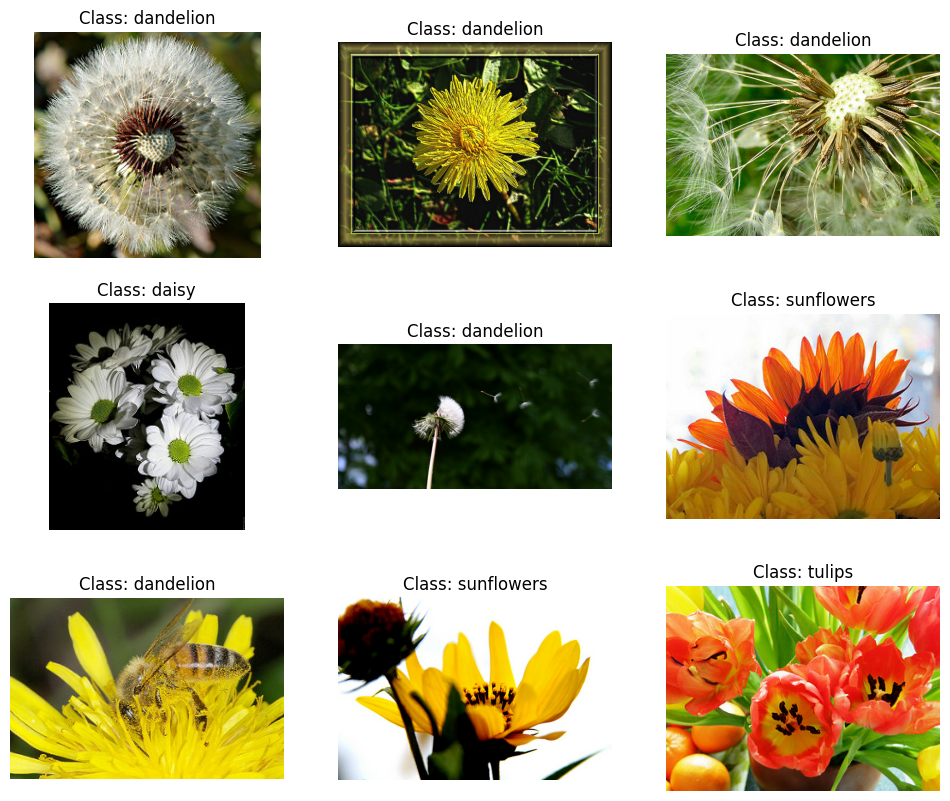

In [46]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

### 5.2 Prétraitement des données

#### 5.2.1 Prétraitements classiques

On a déjà vu comment faire cela. On définit une fonction `preprocess`:

In [47]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

#### 5.2.2 Augmentation de la taille de la base d'images (Data Augmentation)

Quand on a une base d'images de taille réduite, une technique ultraclassique est de réaliser des tranformations des images qu'on donne en entrée du réseau au moment de l'apprentissage. Ces transformations sont réalisés aléatoirement lors de l'apprentissage.

Ce procédé permet d'augmenter virtuellement la taille de la base d'apprentissage et d'indiquer (virtuellement aussi) que ces transformations ne sont pas à considérer pour prédire le label.
Il est évident que le choix des transformations est essentiel et doit représenter la physique du phénomène. Dans le domaine optique, on va rencontrer fréquemment des rotations, flip, du croping, des décalages d'image, etc.

Un exemple possible est celui-là:

In [48]:
#
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

#
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

# Nouvelle fonction preprocess
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)

    return final_image, label



Construisons maintenant des iterateurs comme lors du dernier TP.
On va:
- réaliser un mélange de la base d'apprentissage
- appliquer preprocess à tous les exemples
- mettre en batch de taille 32

Voila le code correspondant

In [49]:
from functools import partial
batch_size = 32

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True))
train_set = train_set.batch(batch_size)

valid_set = valid_set_raw.map(preprocess).batch(batch_size)
test_set = test_set_raw.map(preprocess).batch(batch_size)

Regardons ce qu'il y a dans le train_set

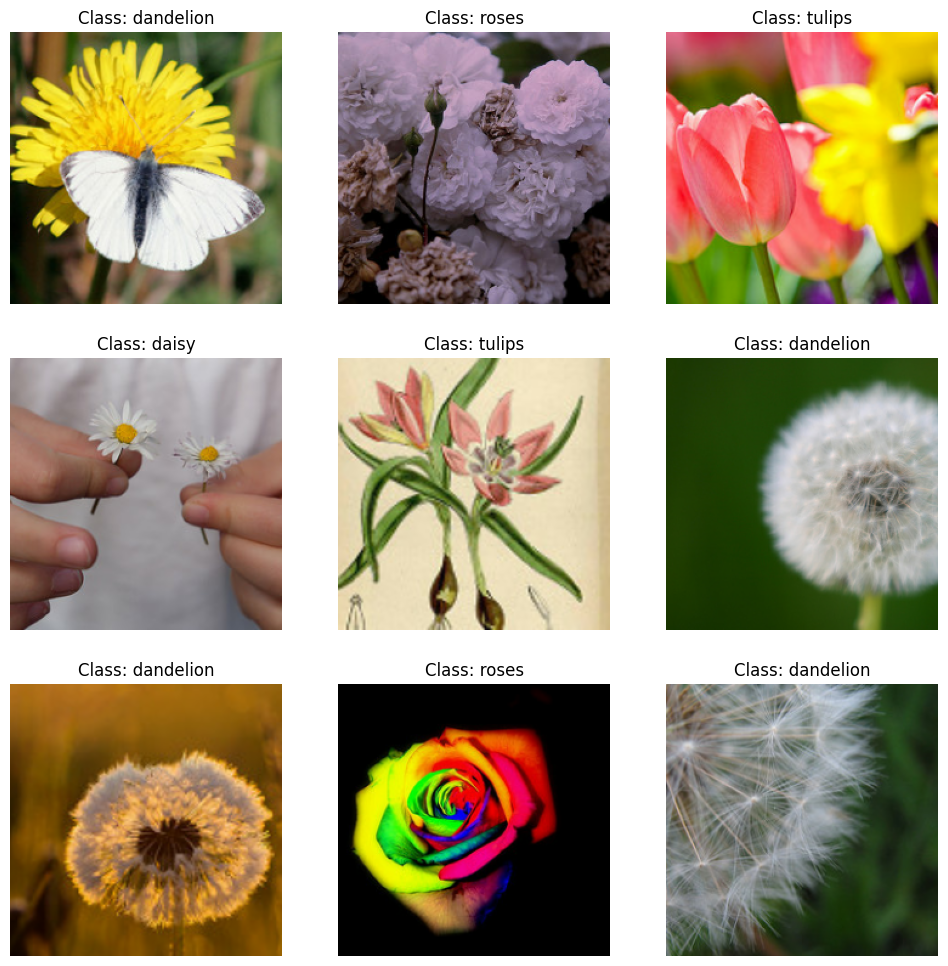

In [50]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

### 5.3 Modification du modèle pour le fine tuning

#### 5.3.1 Chargement du modèle
Chargeons un modèle Xception, pré-entraîné sur ImageNet. Nous excluons le classifieur (i.e. le haut du réseau en définissant `include_top=False` ). Ceci exclut la couche de mise en commun de la moyenne globale et la couche de sortie dense (le classifieur).

In [51]:
# chargement du feature extractor (sans classifieur include_top=False)
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

#### 5.3.2 Modification de l'architecture
Nous ajoutons ensuite notre propre couche de mise en commun de la moyenne globale, basée sur la sortie du modèle de base, suivie d'une couche de sortie dense avec une unité par classe, en utilisant la fonction d'activation softmax. Enfin, nous créons le modèle Keras :

In [52]:
# on rajoute séquentiellement des couches de classification
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

# on a recréé le modèle en liant l'entrée de base_model à la sortie
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [53]:
# check the model architecture (ou model.summary)
model.summary()
# for index, layer in enumerate(base_model.layers):
#     print(index, layer.name)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

#### 5.3.3 Gel des paramètres

Pour faire du fine tuning, on considère que le modèle pré-entrainé possède un extracteur de features efficace. Il s'agit alors de geler les paramètres liés à cet extracteur de features (au moins au début de l'apprentissage).


In [54]:
# Principe du fine-tuning = on fixe le feature extractor pendant l'apprentissage
for layer in base_model.layers:
    layer.trainable = False


# paramètres
NB_EPOCHS = 5

#  Choix de la tâche à effectuer = choix de la fonction de loss/pertes/coûts à minimise
loss_fcn = "sparse_categorical_crossentropy"  # par alias
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()# sans alias

# choix de l'optimiseur (Comment résoudre la tâche de minimisation )
optimizer_fcn = tf.keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)

# Comment évaluer les performances lors de l'apprentissage
#metrics_fcn = ["accuracy"] # par alias
metrics_fcn = [tf.keras.metrics.SparseCategoricalAccuracy()] # sans alias
#metrics_fcn = tf.keras.metrics.SparseCategoricalAccuracy() # sans alias

# compilation ...
model.compile(loss=loss_fcn, optimizer=optimizer_fcn, metrics=metrics_fcn)

#... et entrainement
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=NB_EPOCHS)






Epoch 1/5
86/86 [==============================] - 20s 164ms/step - loss: 1.4137 - sparse_categorical_accuracy: 0.7965 - val_loss: 0.8323 - val_sparse_categorical_accuracy: 0.8676
Epoch 2/5
86/86 [==============================] - 13s 154ms/step - loss: 0.5676 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.9291 - val_sparse_categorical_accuracy: 0.8511
Epoch 3/5
86/86 [==============================] - 13s 150ms/step - loss: 0.3319 - sparse_categorical_accuracy: 0.9215 - val_loss: 0.7656 - val_sparse_categorical_accuracy: 0.8658
Epoch 4/5
86/86 [==============================] - 13s 151ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9408 - val_loss: 0.7302 - val_sparse_categorical_accuracy: 0.8713
Epoch 5/5
86/86 [==============================] - 14s 158ms/step - loss: 0.1894 - sparse_categorical_accuracy: 0.9455 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.8603


Après avoir entraîné le modèle pendant quelques époques, sa précision de validation devrait atteindre environ 75-80%, et ne plus faire de progrès. Cela signifie que les couches supérieures sont maintenant assez bien entraînées, nous sommes donc prêts à dégeler toutes les couches (ou vous pouvez essayer de dégeler seulement les couches supérieures), et continuer l'entraînement (n'oubliez pas de compiler le modèle lorsque vous gelez ou dégeler des couches).



In [ ]:
# On dégèle les couches
for layer in base_model.layers:
    layer.trainable = True

# paramètres
NB_EPOCHS = 40
LEARNING_RATE = 0.01
MOMENTUM = 0.9
DECAY = 0.001

#  Choix de la tâche à effectuer = choix de la fonction de loss/pertes/coûts à minimise
loss_fcn = "sparse_categorical_crossentropy"  # par alias
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()# sans alias

# choix de l'optimiseur (Comment résoudre la tâche de minimisation )
optimizer_fcn = keras.optimizers.legacy.SGD(learning_rate=LEARNING_RATE,
                                     momentum=MOMENTUM, decay=DECAY, nesterov=True)

# Comment évaluer les performances lors de l'apprentissage
metrics_fcn = ["accuracy"] # par alias
# metrics_fcn = tf.keras.metrics.Accuracy() # sans alias

# compilation ...
model.compile(loss=loss_fcn, optimizer=optimizer_fcn, metrics=metrics_fcn)

#... et entrainement
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=NB_EPOCHS)




Epoch 1/40
86/86 [==============================] - 62s 537ms/step - loss: 0.3480 - accuracy: 0.8870 - val_loss: 0.6995 - val_accuracy: 0.8474
Epoch 2/40
86/86 [==============================] - 43s 503ms/step - loss: 0.1376 - accuracy: 0.9589 - val_loss: 0.4225 - val_accuracy: 0.8860
Epoch 3/40
86/86 [==============================] - 44s 516ms/step - loss: 0.0704 - accuracy: 0.9804 - val_loss: 0.2539 - val_accuracy: 0.9357
Epoch 4/40
86/86 [==============================] - 44s 510ms/step - loss: 0.0540 - accuracy: 0.9836 - val_loss: 0.3224 - val_accuracy: 0.9246
Epoch 5/40
86/86 [==============================] - 44s 510ms/step - loss: 0.0403 - accuracy: 0.9847 - val_loss: 0.3051 - val_accuracy: 0.9228
Epoch 6/40
86/86 [==============================] - 44s 510ms/step - loss: 0.0199 - accuracy: 0.9942 - val_loss: 0.3109 - val_accuracy: 0.9191
Epoch 7/40
86/86 [==============================] - 44s 509ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.3099 - val_accuracy: 0.9210

Cela prendra un certain temps, mais ce modèle devrait atteindre une précision d'environ 95 % sur l'ensemble de test.


Vous pouvez passer au tp2.2 maintenant, dans lequel c'est à vous de jouer.
